### **Empirical Testings on CAPM Availability**

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Sat July 12 17:36:01 2021

@author: Bradley

Code for recurring FIN3080 Project 1 - Case 1
"""

'\nCreated on Sat July 12 17:36:01 2021\n\n@author: Bradley\n\nCode for recurring FIN3080 Project 1 - Case 1\n'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 

### **Time Series and Fama-MacBeth Regression**

In [7]:
riskfree = 0.01*0.0286
mkt_return = pd.read_csv('./data/case1_market_return.csv')
mkt_return.columns = ['type', 'month', 'mkt_return']
mkt_return = mkt_return[mkt_return['type'] == 5] #type=5在CSMAR代表全体A股市场
mkt_return.tail()

,type,month,mkt_return
1810,5,2020-49,0.011854
1819,5,2020-50,-0.032570
1828,5,2020-51,0.015323
1837,5,2020-52,0.002290
1846,5,2020-53,0.022778


In [8]:
del mkt_return['type']
mkt_return.set_index('month', inplace=True)
mkt_return.tail()

,mkt_return
month,
2020-49,0.011854
2020-50,-0.032570
2020-51,0.015323
2020-52,0.002290
2020-53,0.022778


In [9]:
mkt_return.isnull().sum()

mkt_return    0
dtype: int64

In [10]:
stock_return = pd.read_csv('./data/case1_stock_return.csv')
stock_return.columns = ['code', 'month', 'return', 'type']
stock_return = stock_return[(stock_return['type']==1) | (stock_return['type']==4)] #沪深主板+中小板
stock_return['code'] = stock_return['code'].apply(lambda x: "%06d"%x)
stock_return.tail()

,code,month,return,type
721196,605399,2020-51,0.014614,1
721197,605399,2020-52,-0.076646,1
721198,605399,2020-53,-0.012256,1
721199,605500,2020-52,NaN,1
721200,605500,2020-53,-0.132775,1


In [11]:
del stock_return['type']
stock_return.set_index('month',inplace=True)
stock_return.tail()

,code,return
month,,
2020-51,605399,0.014614
2020-52,605399,-0.076646
2020-53,605399,-0.012256
2020-52,605500,NaN
2020-53,605500,-0.132775


In [12]:
stock_return.isnull().sum()

code        0
return    601
dtype: int64

In [13]:
# 接下来把无风险、市场、个股回报率拼到一起，不用merge，直接赋值python自动根据index进行匹配
stock_return['mkt_return'] = mkt_return['mkt_return']
stock_return['riskfree'] = riskfree
stock_return.sort_index(inplace=True)
stock_return

,code,return,mkt_return,riskfree
month,,,,
2017-01,000001,0.003297,0.017971,0.000286
2017-01,600887,0.002841,0.017971,0.000286
2017-01,000923,-0.091441,0.017971,0.000286
2017-01,600886,0.013493,0.017971,0.000286
2017-01,000925,0.009361,0.017971,0.000286
...,...,...,...,...
2020-53,600785,0.018504,0.022778,0.000286
2020-53,600608,0.002445,0.022778,0.000286
2020-53,002075,-0.016143,0.022778,0.000286


In [14]:
# 分成三组时间段，每组68-69周
time = stock_return.index
time = list(set(time)) #去除重复
time.sort()
len(time)

206

In [15]:
period1 = time[:68] #共68周
period2 = time[68:137] #共69周
period3 = time[137:] #共69周
group1 = stock_return.loc[period1[0]:period1[-1]]
group2 = stock_return.loc[period2[0]:period2[-1]]
group3 = stock_return.loc[period3[0]:period3[-1]]
group1.to_csv('./processed_data/case1_group1.csv',index=True)
group2.to_csv('./processed_data/case1_group2.csv',index=True)
group3.to_csv('./processed_data/case1_group3.csv',index=True)

In [16]:
# 第一步，回归得到个股beta
# 由于是个股的时间序列回归，应该先根据code进行sort
group1 = pd.read_csv('./processed_data/case1_group1.csv')
group1['code'] = group1['code'].apply(lambda x: "%06d"%x)
group1 = group1.sort_values(by=['code','month'])
group1 = group1.dropna(subset=['return'])
a = group1.groupby('code').size() #把68周中间停牌很多月或退市的股票删除
del_code = a[a.values<68].index
group1.set_index('code', inplace=True)
group1.drop(del_code, inplace=True) #删去全部交易小于68周的股票
group1['excess_ret'] = group1['return'] - group1['riskfree']
group1['excess_mkt_ret'] = group1['mkt_return'] - group1['riskfree']
group1.reset_index(drop=False, inplace=True)
group1

,code,month,return,mkt_return,riskfree,excess_ret,excess_mkt_ret
0,000001,2017-01,0.003297,0.017971,0.000286,0.003011,0.017685
1,000001,2017-02,0.003286,-0.016516,0.000286,0.003000,-0.016802
2,000001,2017-03,0.006550,-0.000548,0.000286,0.006264,-0.000834
3,000001,2017-04,0.011931,0.013777,0.000286,0.011645,0.013491
4,000001,2017-05,-0.007503,-0.005529,0.000286,-0.007789,-0.005815
...,...,...,...,...,...,...,...
109203,603999,2018-13,0.088889,0.010324,0.000286,0.088603,0.010038
109204,603999,2018-14,-0.032653,-0.012212,0.000286,-0.032939,-0.012498
109205,603999,2018-15,0.082982,0.005913,0.000286,0.082696,0.005627
109206,603999,2018-16,-0.059740,-0.027982,0.000286,-0.060026,-0.028268


In [17]:
a = group1.groupby('code').size()
len(a) 
#筛选完所有停过牌和退市的股票，只剩了1606只

1606

In [18]:
# 简单试一下回归功能
test = group1[group1['code']=='000001']
test.dropna(inplace=True) #缺失值不参与回归
y = test['excess_ret']
X = test['excess_mkt_ret']
X = sm.add_constant(X) #statsmodel不会自动加上回归常数项
regression = sm.OLS(y, X).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     22.22
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           1.30e-05
Time:                        21:22:07   Log-Likelihood:                 122.32
No. Observations:                  68   AIC:                            -240.6
Df Residuals:                      66   BIC:                            -236.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0032      0.005      0.

In [19]:
regression.params.tolist() #第一个是常数项，第二个是beta
regression.tvalues.tolist()
regression.pvalues.tolist()
regression.rsquared
regression.rsquared_adj
regression.nobs
# 更多结果属性参考：
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults

[0.0031844621463534835, 1.2107223576188593]

[0.6459549790315443, 4.713742968336488]

[0.5205482187297679, 1.3001378586683226e-05]

0.2518650050832071

0.24052962637234654

68.0

In [20]:
# 如果无脑的话，直接写个for对groupby对象进行循环，分别每个group做一次regression，但for循环要比apply慢太多了
# for code, group in group1.groupby('code'):
#     print(code)
#     print(group)
#     break
def linear_regression(y, x):
    x = x.to_numpy()
    y = y.to_numpy()
    X = sm.add_constant(x) #加上常数项
    model = sm.OLS(y, X)
    rs = model.fit()
    return [rs.nobs] + rs.params.tolist() + rs.tvalues.tolist() + rs.pvalues.tolist() + [rs.rsquared] + [rs.rsquared_adj]
# params、tvalues、pvalues都是两项，第一项是截距项的，第二项是回归项的
result1 = group1.groupby('code').apply(lambda df: linear_regression(df['excess_ret'], df['excess_mkt_ret']))
result1.head() #得到的是个series

code
000001    [68.0, 0.0031844621463534835, 1.21072235761885...
000002    [68.0, 0.005918571311551879, 1.461561409843654...
000005    [68.0, -0.009334298431384514, 1.08324589980057...
000009    [68.0, -0.008236949827252484, 1.07687246070499...
000010    [68.0, -0.011435183928208697, 1.64741587168658...
dtype: object

In [21]:
reg1 = pd.DataFrame(dict(zip(result1.index, result1.values))).T # 把两个list打包成字典，然后直接弄出dataframe
reg1.columns = ['obs','coef', 'beta', 'coef_tvalue', 'beta_tvalue', 'coef_pvalue', 'beta_pvalue', 'Rsquared', 'adj_Rsquared']
reg1.index.name = 'code'
reg1.to_csv('./processed_data/case1_stage1_regression.csv', index=True)
reg1.head()

,obs,coef,beta,coef_tvalue,beta_tvalue,coef_pvalue,beta_pvalue,Rsquared,adj_Rsquared
code,,,,,,,,,
000001,68.0,0.003184,1.210722,0.645955,4.713743,0.520548,1.300138e-05,0.251865,0.240530
000002,68.0,0.005919,1.461561,1.044083,4.948693,0.300256,5.441561e-06,0.270634,0.259583
000005,68.0,-0.009334,1.083246,-2.657068,5.918384,0.009876,1.281439e-07,0.346711,0.336813
000009,68.0,-0.008237,1.076872,-1.926905,4.835188,0.058298,8.306159e-06,0.261572,0.250384
000010,68.0,-0.011435,1.647416,-1.713723,4.738664,0.091273,1.186389e-05,0.253857,0.242552


In [22]:
# 排序根据β分为十个组合
stage1 = pd.read_csv('./processed_data/case1_stage1_regression.csv')
stage1['code'] = stage1['code'].map(lambda x: "%06d"%x)
stage1 = stage1[['code', 'beta']]
stage1.sort_values(by=['beta'], inplace=True)
stage1.reset_index(drop=True, inplace=True)
stage1['rank'] = stage1['beta'].rank(pct=True) #分十个组合就加一列rank代表百分位排名
# 只要有rank就可以添加分组变量。我们肯定希望比如[0.2,0.3)之间的数都分到第三组，可以乘10取整再加一。但是如果乘10后是整数，比如rank是1，那么这样就会得到11，显然不对，所以用一个where函数，如果乘10是整数，就不加那个1
stage1['group'] = np.where(10*(stage1['rank']-stage1['rank']//1)>0, 10*stage1['rank']//1 + 1, 10*stage1['rank']//1) 
stage1.set_index('code', inplace=True) #把股票代码设为index，方便下面第二阶段对每个股票打上分组标签
stage1

,beta,rank,group
code,,,
600313,-0.806731,0.000623,1.0
600518,0.073364,0.001245,1.0
002028,0.101599,0.001868,1.0
600088,0.126969,0.002491,1.0
600280,0.172008,0.003113,1.0
...,...,...,...
601155,2.241824,0.997509,10.0
000732,2.249962,0.998132,10.0
002320,2.257049,0.998755,10.0


In [23]:
# 第二步，先根据上面stage1的beta分组，对code进行分组，然后每组再时间序列回归
# 由于是个股的时间序列回归，应该先根据code进行sort
group2 = pd.read_csv('./processed_data/case1_group2.csv')
group2['code'] = group2['code'].apply(lambda x: "%06d"%x)
group2 = group2.sort_values(by=['code','month'])
group2.set_index('code', inplace=True)
group2['group'] = stage1['group'] #依据index匹配产生分组标签，匹配不上的股票可能就是停牌或退市那些，一会全部扔掉
group2

,month,return,mkt_return,riskfree,group
code,,,,,
000001,2018-18,-0.015668,0.005087,0.000286,7.0
000001,2018-19,0.030899,0.024653,0.000286,7.0
000001,2018-20,-0.004541,0.007794,0.000286,7.0
000001,2018-21,-0.033759,-0.018444,0.000286,7.0
000001,2018-22,-0.037771,-0.021159,0.000286,7.0
...,...,...,...,...,...
603999,2019-32,-0.071154,-0.033452,0.000286,8.0
603999,2019-33,0.132505,0.019956,0.000286,8.0
603999,2019-34,0.171846,0.028547,0.000286,8.0


In [24]:
group2.isnull().sum()
# 有八万多个group是没匹配上的，所以现在全部删掉

month             0
return          104
mkt_return        0
riskfree          0
group         81879
dtype: int64

In [25]:
group2 = group2.dropna(subset=['return','group']) #没有分组标签的股票都删掉，return缺失的也删掉
a = group2.groupby(level=0).size() #把68周中间停牌很多月或退市的股票删除
del_code = a[a.values<68].index
group2.drop(del_code, inplace=True) #再删去第二段时间内，交易小于68周的股票，防止下面回归的时候p值什么的又不全
group2['excess_ret'] = group2['return'] - group2['riskfree']
group2['excess_mkt_ret'] = group2['mkt_return'] - group2['riskfree']
group2.reset_index(drop=False, inplace=True)
group2

,code,month,return,mkt_return,riskfree,group,excess_ret,excess_mkt_ret
0,000001,2018-18,-0.015668,0.005087,0.000286,7.0,-0.015954,0.004801
1,000001,2018-19,0.030899,0.024653,0.000286,7.0,0.030613,0.024367
2,000001,2018-20,-0.004541,0.007794,0.000286,7.0,-0.004827,0.007508
3,000001,2018-21,-0.033759,-0.018444,0.000286,7.0,-0.034045,-0.018730
4,000001,2018-22,-0.037771,-0.021159,0.000286,7.0,-0.038057,-0.021445
...,...,...,...,...,...,...,...,...
104755,603999,2019-32,-0.071154,-0.033452,0.000286,8.0,-0.071440,-0.033738
104756,603999,2019-33,0.132505,0.019956,0.000286,8.0,0.132219,0.019670
104757,603999,2019-34,0.171846,0.028547,0.000286,8.0,0.171560,0.028261
104758,603999,2019-35,-0.123245,-0.003429,0.000286,8.0,-0.123531,-0.003715


In [26]:
result2 = pd.DataFrame()
for i in range(10):
    por = group2[group2['group'] == i+1]
    por_ret = por.groupby('month')['return'].mean()
    result2["port%d_ret"%(i+1)] = por_ret
result2['riskfree'] = group2.groupby('month')['riskfree'].mean()
result2['mkt_return'] = group2.groupby('month')['mkt_return'].mean()
result2.to_csv('./processed_data/case1_portfolio_return.csv',index=True)
result2.head()

,port1_ret,port2_ret,port3_ret,port4_ret,port5_ret,port6_ret,port7_ret,port8_ret,port9_ret,port10_ret,riskfree,mkt_return
month,,,,,,,,,,,,
2018-18,0.007005,0.009477,0.004585,0.009410,0.010733,0.010305,0.008856,-0.000235,-0.000842,0.002202,0.000286,0.005087
2018-19,0.012921,0.017687,0.016133,0.020471,0.022101,0.023906,0.022559,0.027757,0.034408,0.034399,0.000286,0.024653
2018-20,0.002498,0.007531,0.004183,0.010109,0.005362,0.006886,0.005754,0.002675,0.004892,0.008719,0.000286,0.007794
2018-21,-0.003246,-0.000619,-0.009128,-0.000126,-0.002480,-0.010103,-0.009881,-0.011282,-0.011273,-0.006143,0.000286,-0.018444
2018-22,-0.026264,-0.026221,-0.024188,-0.027894,-0.031874,-0.037018,-0.040036,-0.050701,-0.045509,-0.058685,0.000286,-0.021159


In [27]:
# 第二阶段：十个组合时间序列回归
result2 = pd.read_csv('./processed_data/case1_portfolio_return.csv', index_col=0)
# 算超额收益
for i in range(10):
    result2['port%d_excess'%(i+1)] = result2['port%d_ret'%(i+1)] - riskfree
    del result2['port%d_ret'%(i+1)]
result2['excess_mkt_ret'] = result2['mkt_return'] - result2['riskfree']
del result2['riskfree']
del result2['mkt_return']
result2.head()

,port1_excess,port2_excess,port3_excess,port4_excess,port5_excess,port6_excess,port7_excess,port8_excess,port9_excess,port10_excess,excess_mkt_ret
month,,,,,,,,,,,
2018-18,0.006719,0.009191,0.004299,0.009124,0.010447,0.010019,0.008570,-0.000521,-0.001128,0.001916,0.004801
2018-19,0.012635,0.017401,0.015847,0.020185,0.021815,0.023620,0.022273,0.027471,0.034122,0.034113,0.024367
2018-20,0.002212,0.007245,0.003897,0.009823,0.005076,0.006600,0.005468,0.002389,0.004606,0.008433,0.007508
2018-21,-0.003532,-0.000905,-0.009414,-0.000412,-0.002766,-0.010389,-0.010167,-0.011568,-0.011559,-0.006429,-0.018730
2018-22,-0.026550,-0.026507,-0.024474,-0.028180,-0.032160,-0.037304,-0.040322,-0.050987,-0.045795,-0.058971,-0.021445


In [28]:
def linear_regression(y, x):
    x = x.to_numpy()
    y = y.to_numpy()
    X = sm.add_constant(x) #加上常数项
    model = sm.OLS(y, X)
    rs = model.fit()
    return [rs.nobs] + rs.params.tolist() + rs.tvalues.tolist() + rs.pvalues.tolist() + [rs.rsquared] + [rs.rsquared_adj]
# params、tvalues、pvalues都是两项，第一项是截距项的，第二项是回归项的

a = []
b = []
for i in range(10):
    a.append('port_%d'%(i+1))
    b.append(linear_regression(result2['port%d_excess'%(i+1)], result2['excess_mkt_ret']))
reg2 = pd.DataFrame(dict(zip(a,b))).T
reg2.columns = ['obs','coef', 'beta', 'coef_tvalue', 'beta_tvalue', 'coef_pvalue', 'beta_pvalue', 'Rsquared', 'adj_Rsquared']
reg2.to_csv('./processed_data/case1_stage2_regression.csv', index=True)
reg2

,obs,coef,beta,coef_tvalue,beta_tvalue,coef_pvalue,beta_pvalue,Rsquared,adj_Rsquared
port_1,69.0,-0.000508,1.010320,-0.376619,21.561773,0.707647,7.473787e-32,0.874039,0.872159
port_2,69.0,-0.000359,1.044319,-0.289610,24.226385,0.773009,7.303330e-35,0.897541,0.896011
port_3,69.0,0.000185,1.067529,0.127987,21.258567,0.898543,1.713280e-31,0.870887,0.868960
port_4,69.0,0.000229,1.077582,0.153610,20.759953,0.878379,6.834723e-31,0.865455,0.863447
port_5,69.0,0.000165,1.166705,0.099573,20.271946,0.920980,2.711423e-30,0.859818,0.857726
port_6,69.0,0.000737,1.181153,0.413969,19.076223,0.680219,8.803262e-29,0.844512,0.842192
port_7,69.0,0.000684,1.230666,0.382391,19.785456,0.703382,1.097209e-29,0.853860,0.851679
port_8,69.0,0.000473,1.248788,0.228868,17.370561,0.819669,1.651807e-26,0.818298,0.815586
port_9,69.0,0.000032,1.236725,0.018519,20.560121,0.985280,1.198210e-30,0.863187,0.861145
port_10,69.0,-0.000953,1.309440,-0.499465,19.729286,0.619088,1.291429e-29,0.853149,0.850957


In [29]:
group3 = pd.read_csv('./processed_data/case1_group3.csv')
group3['code'] = group3['code'].apply(lambda x: "%06d"%x)
group3 = group3.sort_values(by=['code','month'])
group3.set_index('code', inplace=True)
group3['group'] = stage1['group'] #依据index匹配产生分组标签，匹配不上的股票可能就是停牌或退市那些，一会全部扔掉
group3

,month,return,mkt_return,riskfree,group
code,,,,,
000001,2019-37,-0.008778,0.009933,0.000286,7.0
000001,2019-38,0.044959,-0.006576,0.000286,7.0
000001,2019-39,0.036506,-0.026985,0.000286,7.0
000001,2019-40,-0.019497,-0.008903,0.000286,7.0
000001,2019-41,0.078255,0.023905,0.000286,7.0
...,...,...,...,...,...
605399,2020-51,0.014614,0.015323,0.000286,NaN
605399,2020-52,-0.076646,0.002290,0.000286,NaN
605399,2020-53,-0.012256,0.022778,0.000286,NaN


In [30]:
group3.isnull().sum()

month             0
return          166
mkt_return        0
riskfree          0
group         91352
dtype: int64

In [31]:
group3 = group3.dropna(subset=['return','group']) #没有分组标签的股票都删掉，return缺失的也删掉
a = group3.groupby(level=0).size() #把68周中间停牌很多月或退市的股票删除
del_code = a[a.values<68].index
group3.drop(del_code, inplace=True) #再删去第二段时间内，交易小于68周的股票，防止下面回归的时候p值什么的又不全
group3.reset_index(drop=False, inplace=True)
group3

,code,month,return,mkt_return,riskfree,group
0,000001,2019-37,-0.008778,0.009933,0.000286,7.0
1,000001,2019-38,0.044959,-0.006576,0.000286,7.0
2,000001,2019-39,0.036506,-0.026985,0.000286,7.0
3,000001,2019-40,-0.019497,-0.008903,0.000286,7.0
4,000001,2019-41,0.078255,0.023905,0.000286,7.0
...,...,...,...,...,...,...
107870,603999,2020-49,0.031826,0.011854,0.000286,8.0
107871,603999,2020-50,-0.058442,-0.032570,0.000286,8.0
107872,603999,2020-51,-0.017241,0.015323,0.000286,8.0
107873,603999,2020-52,-0.043860,0.002290,0.000286,8.0


In [32]:
# 得到十个组合再第三阶段的return情况，完全一样的代码
result3 = pd.DataFrame()
for i in range(10):
    por = group3[group3['group'] == i+1]
    por_ret = por.groupby('month')['return'].mean()
    result3["port%d_ret"%(i+1)] = por_ret
result3['riskfree'] = group3.groupby('month')['riskfree'].mean()
result3['mkt_return'] = group3.groupby('month')['mkt_return'].mean()
result3.head()

,port1_ret,port2_ret,port3_ret,port4_ret,port5_ret,port6_ret,port7_ret,port8_ret,port9_ret,port10_ret,riskfree,mkt_return
month,,,,,,,,,,,,
2019-37,0.022476,0.017163,0.013782,0.014134,0.018043,0.022554,0.021798,0.020718,0.023518,0.020442,0.000286,0.009933
2019-38,-0.007340,-0.007167,-0.007029,-0.005723,-0.005912,-0.007667,-0.006320,-0.005024,-0.011561,-0.010675,0.000286,-0.006576
2019-39,-0.033770,-0.037571,-0.035223,-0.037982,-0.038370,-0.046377,-0.037221,-0.041856,-0.040446,-0.043504,0.000286,-0.026985
2019-40,-0.007944,-0.007883,-0.008515,-0.009752,-0.007559,-0.007629,-0.008992,-0.011330,-0.008760,-0.011442,0.000286,-0.008903
2019-41,0.024094,0.023145,0.018550,0.022617,0.022655,0.026063,0.031106,0.025860,0.031352,0.028429,0.000286,0.023905


In [33]:
# 算一下超额
for i in range(10):
    result3['port%d_excess'%(i+1)] = result3['port%d_ret'%(i+1)] - riskfree
    del result3['port%d_ret'%(i+1)]
result3['excess_mkt_ret'] = result3['mkt_return'] - result3['riskfree']
del result3['riskfree']
del result3['mkt_return']
result3.head()

,port1_excess,port2_excess,port3_excess,port4_excess,port5_excess,port6_excess,port7_excess,port8_excess,port9_excess,port10_excess,excess_mkt_ret
month,,,,,,,,,,,
2019-37,0.022190,0.016877,0.013496,0.013848,0.017757,0.022268,0.021512,0.020432,0.023232,0.020156,0.009647
2019-38,-0.007626,-0.007453,-0.007315,-0.006009,-0.006198,-0.007953,-0.006606,-0.005310,-0.011847,-0.010961,-0.006862
2019-39,-0.034056,-0.037857,-0.035509,-0.038268,-0.038656,-0.046663,-0.037507,-0.042142,-0.040732,-0.043790,-0.027271
2019-40,-0.008230,-0.008169,-0.008801,-0.010038,-0.007845,-0.007915,-0.009278,-0.011616,-0.009046,-0.011728,-0.009189
2019-41,0.023808,0.022859,0.018264,0.022331,0.022369,0.025777,0.030820,0.025574,0.031066,0.028143,0.023619


#### **Method 1: Direct Cross-Sectional Regression**
**Taking mean return of period 3 data and run regression once to obtain the final result**

In [34]:
cross_section_return = result3.mean()
cross_section_return

port1_excess      0.001637
port2_excess      0.002488
port3_excess      0.002491
port4_excess      0.003530
port5_excess      0.003443
port6_excess      0.002995
port7_excess      0.002889
port8_excess      0.002935
port9_excess      0.002030
port10_excess     0.002713
excess_mkt_ret    0.003231
dtype: float64

In [35]:
# 第三阶段是最后69周10个portfolio的截面超额收益，回归第二阶段得到的10个组合的beta值，看系数是否显著
stage3 = pd.read_csv('./processed_data/case1_stage2_regression.csv', index_col=0)
stage3 = stage3[['beta']] #取第二阶段的β，弄成个dataframe方便
stage3['cross_return_excess'] = cross_section_return.values[:10]
stage3.to_csv('./processed_data/case1_stage3_regression.csv', index=True)
stage3

,beta,cross_return_excess
port_1,1.010320,0.001637
port_2,1.044319,0.002488
port_3,1.067529,0.002491
port_4,1.077582,0.003530
port_5,1.166705,0.003443
port_6,1.181153,0.002995
port_7,1.230666,0.002889
port_8,1.248788,0.002935
port_9,1.236725,0.002030
port_10,1.309440,0.002713


In [229]:
# 最后一步回归！！！
y = stage3['cross_return_excess']
x = stage3['beta']
X = sm.add_constant(x) #加常数项
model = sm.OLS(y,X).fit()
print(model.summary())

OLS Regression Results                            
Dep. Variable:     cross_return_excess   R-squared:                       0.060
Model:                             OLS   Adj. R-squared:                 -0.057
Method:                  Least Squares   F-statistic:                    0.5110
Date:                 Sat, 17 Jul 2021   Prob (F-statistic):              0.495
Time:                         18:21:57   Log-Likelihood:                 61.078
No. Observations:                   10   AIC:                            -118.2
Df Residuals:                        8   BIC:                            -117.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.470      0.651      -0.004     

We have deleted stocks that exit the market (退市), temporarily leave (停牌). The obtained regression result is rigorous enough.
- check the t-value of the coefficient and constant
- check R^2 to be 0.06

In [64]:
reg2.describe()

,obs,coef,beta,coef_tvalue,beta_tvalue,coef_pvalue,beta_pvalue,Rsquared,adj_Rsquared
count,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,69.0,0.000069,1.157323,0.025922,20.460027,0.798619,1.663483e-27,0.860075,0.857986
std,0.0,0.000537,0.101460,0.314231,1.783288,0.120580,5.219440e-27,0.020625,0.020932
min,69.0,-0.000953,1.010320,-0.499465,17.370561,0.619088,7.303330e-35,0.818298,0.815586
25%,69.0,-0.000261,1.070042,-0.212578,19.743329,0.704448,2.993641e-31,0.853327,0.851138
50%,69.0,0.000175,1.173929,0.113780,20.416034,0.796339,1.954816e-30,0.861503,0.859435
75%,69.0,0.000412,1.235210,0.210053,21.133913,0.893502,1.242874e-29,0.869529,0.867582
max,69.0,0.000737,1.309440,0.413969,24.226385,0.985280,1.651807e-26,0.897541,0.896011


In [230]:
print(model.summary2())

Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     -0.057    
Dependent Variable: cross_return_excess AIC:                -118.1561 
Date:               2021-07-17 18:23    BIC:                -117.5509 
No. Observations:   10                  Log-Likelihood:     61.078    
Df Model:           1                   F-statistic:        0.5110    
Df Residuals:       8                   Prob (F-statistic): 0.495     
R-squared:          0.060               Scale:              3.6246e-07
--------------------------------------------------------------------------
          Coef.      Std.Err.       t        P>|t|       [0.025     0.975]
--------------------------------------------------------------------------
const     0.0011       0.0023     0.4695     0.6512     -0.0042     0.0064
beta      0.0014       0.0020     0.7149     0.4950     -0.0031     0.0060
----------------------------------------------------------------------
Omnibus:                 

In [232]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     cross_return_excess   R-squared:                       0.060
Model:                             OLS   Adj. R-squared:                 -0.057
Method:                  Least Squares   F-statistic:                    0.5110
Date:                 Sat, 17 Jul 2021   Prob (F-statistic):              0.495
Time:                         18:24:19   Log-Likelihood:                 61.078
No. Observations:                   10   AIC:                            -118.2
Df Residuals:                        8   BIC:                            -117.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.470      0.651      -0.004       0.006
beta           0.0014      0.002      0.715      0.495      -0.003       0.006
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.998   Jarque-Bera (JB):                0.170
Skew:                           0.001   Prob(JB):                        0.918
Kurtosis:                       2.361   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**beautify the plot:**
- using stata
- use colormap in python
- use `fill` method to draw scatterplot + fitted line + confidence interval
- use joinplot in seaborn

由于我们只分了十个组合，这个散点图不好看，可以分100个组合（报告里是分了100个组合）

<AxesSubplot:xlabel='beta', ylabel='cross_return_excess'>

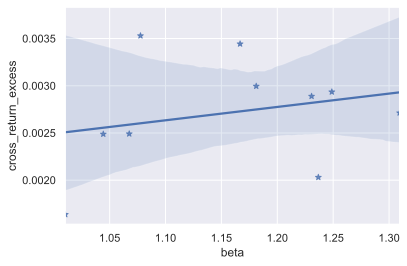

In [245]:
sns.set_theme(color_codes=True)
sns.regplot(x='beta', y='cross_return_excess', data=stage3, marker="*")

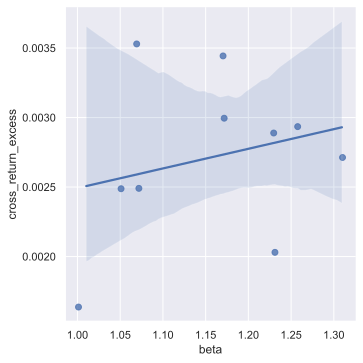

In [252]:
sns.lmplot(x='beta', y='cross_return_excess', data=stage3,x_jitter=.01)

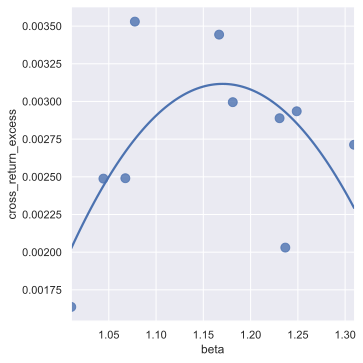

In [250]:
sns.lmplot(x='beta', y='cross_return_excess', data=stage3,
           order=2, ci=None, scatter_kws={"s": 80}) #二阶拟合

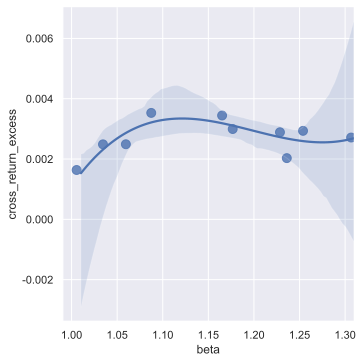

In [267]:
sns.lmplot(x='beta', y='cross_return_excess', data=stage3,
           order=3, scatter_kws={"s": 80}, x_jitter=.01) #三阶拟合

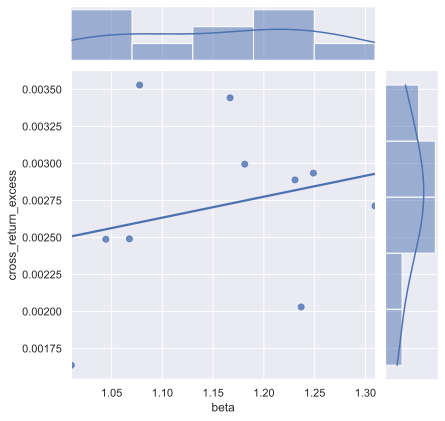

In [256]:
sns.jointplot(x='beta', y='cross_return_excess', ci=None,data=stage3, kind='reg')

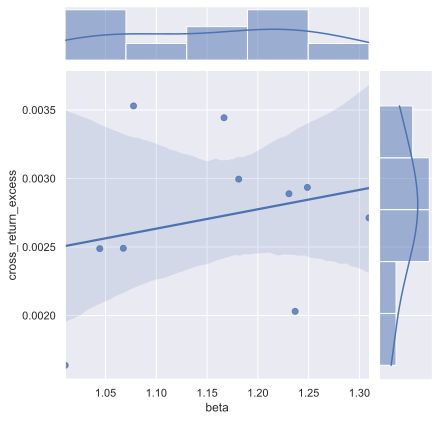

In [268]:
# sns画图会自动指明ci，就是打不打阴影。指明ci就可以画置信区间，参数ci=...需要是一列ndarray
sns.jointplot(x='beta', y='cross_return_excess', data=stage3, kind='reg')
plt.savefig('./figures/CAPM2.png', dpi=1000)

#### **Method 2: Fama-MacBeth Regression**
**上一种直接做一个截面回归的方法其实有很大的误差，算出来的标准误不准确，受到了单独portfolio残差截面相关性的影响，况且最后就十个点在拟合线性，因为我们就十个portfolio，这样的结果也不严谨。正确的方法是使用Fama-MacBeth Regression，时序上拟合多个线性模型再取平均值作为参数估计。**

For period 3, use the beta from stage 2 as the independent variable X, which remains constant for the stage 3. **Then run a cross-sectional regression for every month in stage 3.** Lastly take mean of the coefficient as the final estimate: coefficient for the factor (here is beta) is the mean level of factor return (因子收益率平均值) and the constant term is mean level of idiosyncratic residuals (个股残差均值).

**By doing regression first and then taking the mean, Fama-MacBeth Regression rules out the effect of correlation between cross-sectional residuals on the accuracy of final estimated standard error of the coefficient (排除了残差截面相关性对标准误的影响。股票的残差收益率在截面上具有很高的相关性，因此该修正对于准确计算标准误至关重要).**

In [38]:
stage3_2 = pd.read_csv('./processed_data/case1_stage2_regression.csv', index_col=0)
stage3_2 = stage3[['beta']] #取第二阶段的β，弄成个dataframe方便
stage3_2

,beta
port_1,1.010320
port_2,1.044319
port_3,1.067529
port_4,1.077582
port_5,1.166705
port_6,1.181153
port_7,1.230666
port_8,1.248788
port_9,1.236725
port_10,1.309440


In [41]:
result1

code
000001    [68.0, 0.0031844621463534835, 1.21072235761885...
000002    [68.0, 0.005918571311551879, 1.461561409843654...
000005    [68.0, -0.009334298431384514, 1.08324589980057...
000009    [68.0, -0.008236949827252484, 1.07687246070499...
000010    [68.0, -0.011435183928208697, 1.64741587168658...
                                ...                        
603990    [68.0, -0.00389257672488876, 0.772210581709055...
603993    [68.0, 0.012466782423143188, 2.004534340230717...
603996    [68.0, -0.0024137888094368284, 0.6218772090564...
603997    [68.0, 0.00017905414019918527, 0.6140630235922...
603999    [68.0, -0.010199128666671664, 1.37098188469369...
Length: 1606, dtype: object

In [43]:
stage3_2['beta'].values

array([1.01031992, 1.04431879, 1.06752909, 1.0775822 , 1.1667047 ,
       1.18115307, 1.23066644, 1.2487881 , 1.23672479, 1.30943954])

In [45]:
result3.iloc[0].values

array([0.02218969, 0.01687657, 0.01349631, 0.01384842, 0.01775652,
       0.02226845, 0.02151156, 0.02043218, 0.02323242, 0.0201558 ,
       0.009647  ])

In [49]:
def linear_regression(y, x):
    x = x.to_numpy()
    y = y.to_numpy()
    X = sm.add_constant(x) #加上常数项
    model = sm.OLS(y, X)
    rs = model.fit()
    return [rs.nobs] + rs.params.tolist() + rs.tvalues.tolist() + rs.pvalues.tolist() + [rs.rsquared] + [rs.rsquared_adj]
# params、tvalues、pvalues都是两项，第一项是截距项的，第二项是回归项的

# 对每一行，即每个t进行操作
result3_2 = result3.apply(lambda x: linear_regression(x[:10], stage3_2['beta']), axis=1)
result3_2.head()

month
2019-37    [10.0, -0.00042725517097990176, 0.016939137397...
2019-38    [10.0, 0.001348616123743063, -0.00784264984587...
2019-39    [10.0, -0.008897928591460505, -0.0264577243558...
2019-40    [10.0, 0.0005260532177928379, -0.0084615802518...
2019-41    [10.0, -0.008225013631154295, 0.02879596715120...
dtype: object

In [52]:
# 处理数据格式
reg3_2 = pd.DataFrame(dict(zip(result3_2.index, result3_2.values))).T # 把两个list打包成字典，然后直接弄出dataframe
reg3_2.columns = ['obs','residual', 'coef_of_beta', 'residual_tvalue', 'coef_tvalue', 'residual_pvalue', 'coef_pvalue', 'Rsquared', 'adj_Rsquared']
reg3_2.index.name = 'month'
reg3_2.to_csv('./processed_data/case1_stage3_Fama_MacBeth_Regression.csv', index=True)
reg3_2.head()

,obs,residual,coef_of_beta,residual_tvalue,coef_tvalue,residual_pvalue,coef_pvalue,Rsquared,adj_Rsquared
month,,,,,,,,,
2019-37,10.0,-0.000427,0.016939,-0.034466,1.586870,0.973350,0.151204,0.239410,0.144337
2019-38,10.0,0.001349,-0.007843,0.170389,-1.150712,0.868935,0.283082,0.142012,0.034763
2019-39,10.0,-0.008898,-0.026458,-0.800960,-2.765833,0.446288,0.024454,0.488812,0.424914
2019-40,10.0,0.000526,-0.008462,0.112879,-2.108569,0.912907,0.068025,0.357226,0.276880
2019-41,10.0,-0.008225,0.028796,-0.728890,2.963525,0.486856,0.018049,0.523312,0.463726


In [61]:
reg3_2

,obs,residual,coef_of_beta,residual_tvalue,coef_tvalue,residual_pvalue,coef_pvalue,Rsquared,adj_Rsquared
month,,,,,,,,,
2019-37,10.0,-0.000427,0.016939,-0.034466,1.586870,0.973350,0.151204,0.239410,0.144337
2019-38,10.0,0.001349,-0.007843,0.170389,-1.150712,0.868935,0.283082,0.142012,0.034763
2019-39,10.0,-0.008898,-0.026458,-0.800960,-2.765833,0.446288,0.024454,0.488812,0.424914
2019-40,10.0,0.000526,-0.008462,0.112879,-2.108569,0.912907,0.068025,0.357226,0.276880
2019-41,10.0,-0.008225,0.028796,-0.728890,2.963525,0.486856,0.018049,0.523312,0.463726
2019-42,10.0,0.003106,-0.017515,0.327274,-2.142897,0.751860,0.064485,0.364676,0.285261
2019-43,10.0,0.000412,0.006202,0.026898,0.470121,0.979200,0.650818,0.026884,-0.094756
2019-44,10.0,0.029166,-0.031676,3.463432,-4.368270,0.008525,0.002386,0.704598,0.667673
2019-45,10.0,0.014887,-0.013620,1.411971,-1.500212,0.195652,0.171950,0.219561,0.122006


**使用macbeth可以得到最终参数的准确估计和标准差，但是因为有很多组回归，因此无法得到一组最后的回归作为可视化**

In [54]:
# 取mean得到最终估计
reg3_2.describe()

,obs,residual,coef_of_beta,residual_tvalue,coef_tvalue,residual_pvalue,coef_pvalue,Rsquared,adj_Rsquared
count,69.0,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,10.0,0.001079,0.001414,0.282902,0.058027,0.367285,0.292659,0.273727,0.182943
std,0.0,0.029447,0.028899,2.142705,2.376648,0.320468,0.297194,0.243650,0.274107
min,10.0,-0.085490,-0.087333,-5.110241,-5.725400,0.000035,0.000110,0.000103,-0.124884
25%,10.0,-0.017720,-0.013558,-0.973272,-1.272454,0.071097,0.040581,0.051127,-0.067483
50%,10.0,0.000526,-0.003823,0.112879,-0.284096,0.327986,0.170049,0.221283,0.123943
75%,10.0,0.018139,0.020011,1.041744,1.736126,0.581183,0.529902,0.426621,0.354948
max,10.0,0.074378,0.089957,8.249339,7.021595,0.998251,0.977769,0.860391,0.842940


因此，最终关于市场回报率因子，也就是rm，其因子收益率均值为0.001414，标准差为0.028899，t检验值为0.048929028686，一共69个样本，因此95%的置信区间是[-0.005404900305918262, 0.008232900305918263]，t检验值很小，不能拒绝0假设。平均的R^2有0.18。个股残差均值为0.001079，标准差0.029447，t检验值0.036642102760892456，置信区间为[-0.0058692043430006256,0.008027204343000626]，不能拒绝0假设。

由此，我们用上海主板加中小板得到的结论竟然与fama macbeth的结论吻合。当然，他们采用的是二阶模型的拟合，我们也可以直接添加一项二阶的。结论是：
- 除了市场回报率，没有其他因子会systematically affect the expected returns，因为常数项residual的t检验值很小，并且在上面那张大表展开来看各个regression的情况，其中residual有正有负。
- 二次项系数不显著，因此do not reject the hypothesis that the model is linear
- 然而，beta回归的系数也不显著，也是有正有负。但是别忘了这是month的数据！对于平均的coef是0.0014，意思是the average increment return per unit of beta is 0.14%, so that on average, bearing risk has substantial reward. 